# Fine-tuning SpeechT5 for Text-to-Speech in Dutch

In [1]:
# Installing required dependencies
!pip install transformers datasets soundfile speechbrain accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.2/807.2 kB 10.9 MB/s eta 0:00:0000:010:01


In [2]:
# Log in to Hugging Face account
from huggingface_hub import notebook_login

tebook_login()

In [3]:
# Import required libraries
from datasets import load_dataset, Audio



# Load the Dutch subset of the VoxPopuli dataset
dataset = load_dataset("facebook/voxpopuli", "nl", split="train", trust_remote_code=True)
len(dataset)

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

data/n_files.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

asr_train.tsv:   0%|          | 0.00/7.09M [00:00<?, ?B/s]

asr_dev.tsv:   0%|          | 0.00/422k [00:00<?, ?B/s]

asr_test.tsv:   0%|          | 0.00/405k [00:00<?, ?B/s]

train_part_0.tar.gz:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

train_part_1.tar.gz:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

train_part_2.tar.gz:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

train_part_3.tar.gz:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

train_part_4.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

dev_part_0.tar.gz:   0%|          | 0.00/321M [00:00<?, ?B/s]

test_part_0.tar.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

20968

In [4]:

# Ensure the audio is sampled at 16kHz, as required by SpeechT5
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [5]:
from transformers import SpeechT5Processor


# Load the SpeechT5 checkpoint and processor for text-tokenization and audio preprocessing
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
#text tokenization
tokenizer = processor.tokenizer

In [7]:
# Looking at an example
dataset[0]

{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/94ad18362007da652ce6c405177dd65cc2711a93d5a8f5a6e07b111bd2c47d29/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.27246094e-04,  1.31225586e-03,  1.03759766e-03, ...,
         -9.15527344e-05,  7.62939453e-04, -2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

In [8]:
# Extract characters from the dataset to check for unsupported characters
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

In [9]:
# Find unsupported characters
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

In [10]:
# Define replacements for unsupported characters
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


# Replace unsupported characters in the text data
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

# Apply the cleanup function across the dataset

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

In [11]:
from collections import defaultdict

#count the number of unique speakers and the number of examples each speaker contributes to the dataset.
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

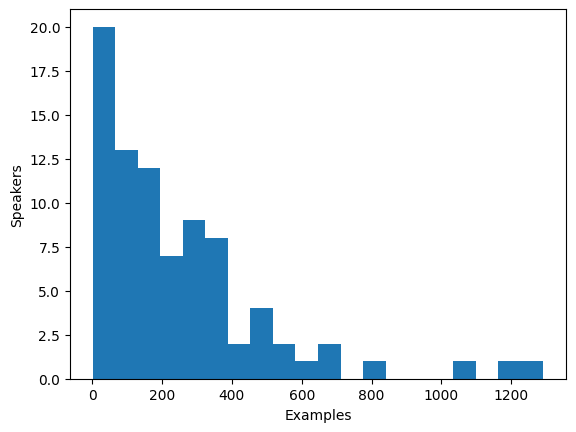

In [12]:
import matplotlib.pyplot as plt

# Plot histogram of speakers and examples
plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [13]:
#The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while 
# around ten speakers have more than 500 examples. To improve training efficiency and balance the dataset, we can limit the
#data to speakers with between 100 and 400 examples.

def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/20968 [00:00<?, ? examples/s]

In [14]:
# Check how many speakers remain
len(set(dataset["speaker_id"]))

42

In [15]:
# Check how many examples remain
len(dataset)

9973

In [16]:
# To enable the TTS model to differentiate between multiple speakers, we need to create a speaker embedding for each example.
# The speaker embedding is an additional input into the model that captures a particular speaker’s voice characteristics. To 
# generate these speaker embeddings we use the pre-trained spkrec-xvect-voxceleb model from SpeechBrain.

# Create a function create_speaker_embedding() that takes an input audio waveform and outputs a 512-element vector 
# containing the corresponding speaker embedding.


import os
import torch
#from speechbrain.pretrained import EncoderClassifier
from speechbrain.inference import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [17]:

# Prepare the dataset by tokenizing text, processing audio, and adding speaker embeddings
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [18]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [19]:
processed_example["speaker_embeddings"].shape

(512,)

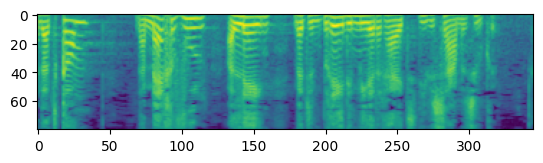

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [21]:
# Apply the function across the dataset
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/9973 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


In [22]:
# Filter out overly long sequences
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

8259

In [23]:
# Split the dataset into training and testing sets
dataset = dataset.train_test_split(test_size=0.1)

In [24]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Custom data collator to handle padding for the text, audio, and speaker embeddings
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [25]:
# Instantiate the data collator
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [26]:
from transformers import SpeechT5ForTextToSpeech

# Load the pre-trained SpeechT5 model
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [27]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [28]:
from transformers import Seq2SeqTrainingArguments

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/speecht5_finetuned_voxpopuli_nl",  
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

In [29]:
from transformers import Seq2SeqTrainer
# Create the trainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [30]:
# Start training
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
1000,0.518800,0.478781
2000,0.493200,0.463028
3000,0.489800,0.457568
4000,0.493400,0.456698


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/opt/conda/lib/python3.10

TrainOutput(global_step=4000, training_loss=0.5226855716705322, metrics={'train_runtime': 10349.3014, 'train_samples_per_second': 12.368, 'train_steps_per_second': 0.386, 'total_flos': 1.7031466950625512e+16, 'train_loss': 0.5226855716705322, 'epoch': 17.21355567509414})

# Inference

In [33]:
# Inference: Load the fine-tuned model for TTS from Kaggle working directory

modelfine = SpeechT5ForTextToSpeech.from_pretrained("/kaggle/working/speecht5_finetuned_voxpopuli_nl/checkpoint-4000/")

# Pick an example and get speaker embedding
example2 = dataset["test"][304]
speaker_embeddingss = torch.tensor(example2["speaker_embeddings"]).unsqueeze(0)

# Input text for TTS
text2 = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

# Preprocess the input text
inputs2 = processor(text=text2, return_tensors="pt")

# Instantiate a vocoder and generate speech
from transformers import SpeechT5HifiGan

# Load the vocoder 
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")



config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [34]:
# Generate speech using the saved and fine tuned model
speech2 = modelfine.generate_speech(inputs2["input_ids"], speaker_embeddings=speaker_embeddingss, vocoder=vocoder)

# Listen to the generated speech
from IPython.display import Audio

Audio(speech2.numpy(), rate=16000)
